In [17]:
import pandas 
import seaborn

import cltrier_lib

import twon_agents

In [18]:
SEED: int = 1
DATA_PATH: str = "../../../data"

In [19]:
post_ids: pandas.DataFrame = (
    pandas.read_csv(f"{DATA_PATH}/interim/twitter.english.posts.csv", index_col=0)
    [["id"]]
)
post_ids

,id
12,1692273284526555392
15,1692224923949805824
17,1691854007113842688
18,1691854006153347072
19,1691854005176074496
...,...
91766,1506739661519081472
91767,1506722331510591488
91768,1506682090124947712
91773,1505981160790315008


In [21]:
replies: pandas.DataFrame = (
    pandas.concat([
        pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_1.csv"),
        pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_2.csv"),
        pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_July.csv"),
        pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_I.csv"),
        pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_II.csv"),
    ])
    .rename(columns={"tweet_id": "id", "full_text": "text", "screen_name": "username", "original_user_id": "author_id"})
    .pipe(lambda _df: _df.assign(
        reply_to_id=pandas.to_numeric(_df["reply_to_id"], errors='coerce').fillna(0).astype("int64"),
        author_id=pandas.to_numeric(_df["author_id"], errors='coerce').fillna(0).astype("int64")
        ))
    .merge(post_ids, left_on="reply_to_id", right_on="id")
    .drop(columns=["id_x"])
    .rename(columns={"id_y": "id"})
)
replies.head()

/tmp/ipykernel_1605504/3156397251.py:7: DtypeWarning: Columns (2,3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_II.csv"),


,text,created_at,username,author_id,retweeted_user_ID,collected_at,reply_to_id,reply_to_user,expandedURL,id
0,@SenRickScott Funny that Hunter is being held ...,2023-07-26 16:11:33+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140046,1684217285567807488,131546062.0,[],1684217285567807488
1,@SenRickScott @JoeBiden You’re lying,2023-07-21 19:48:03+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140187,1682471504880050176,131546062.0,[],1682471504880050176
2,@SenRickScott Why don’t you call Senator Tubbe...,2023-07-21 11:58:42+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140215,1682337371126112512,131546062.0,[],1682337371126112512
3,@SenRickScott OK folks let’s get your shot gla...,2023-07-20 12:12:32+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140254,1681994109094080512,131546062.0,[],1681994109094080512
4,@SenRickScott @JoeBiden Blah blah blah,2023-07-18 22:18:28+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140306,1681424977076322304,131546062.0,[],1681424977076322304


In [24]:
(
    replies
    # remove linebreaks and mentions at beginning
    .assign(text=(
        replies["text"]
        .replace(r"\n"," ", regex=True)
        .replace(r"^@(\w){1,15}\s?(@(\w){1,15})*","", regex=True)
    ))
    [["id", "author_id", "reply_to_id", "created_at", "text"]]
    # .to_csv(f"{DATA_PATH}/interim/twitter.english.replies.csv")
)

,id,author_id,reply_to_id,created_at,text
0,1684217285567807488,1088163738950295552,1684217285567807488,2023-07-26 16:11:33+00:00,Funny that Hunter is being held to account yet...
1,1682471504880050176,1088163738950295552,1682471504880050176,2023-07-21 19:48:03+00:00,You’re lying
2,1682337371126112512,1088163738950295552,1682337371126112512,2023-07-21 11:58:42+00:00,Why don’t you call Senator Tubberville and tel...
3,1681994109094080512,1088163738950295552,1681994109094080512,2023-07-20 12:12:32+00:00,OK folks let’s get your shot glasses out and w...
4,1681424977076322304,1088163738950295552,1681424977076322304,2023-07-18 22:18:28+00:00,Blah blah blah
...,...,...,...,...,...
9593,1672603841127170048,1411161121,1672603841127170048,2023-06-24 18:52:08+00:00,I'll guarantee that if any one of yours or you...
9594,1667892656184127488,1411161121,1667892656184127488,2023-06-11 18:37:40+00:00,Most Republicans threw away their beliefs when...
9595,1687486482334855168,28261183,1687486482334855168,2023-08-05 22:06:39+00:00,Because our legal system sucks like our govern...
9596,1592717086605852672,28261183,1592717086605852672,2022-11-16 16:15:36+00:00,"Republicans AGAINST tRUMP, Voted against him o..."


In [6]:
classified_data = pandas.json_normalize([sample.model_dump() for sample in  cltrier_lib.classify.Pipeline()(list(replies["text"]), threshold=0.)])
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,@SenRickScott Funny that Hunter is being held ...,0.004594,0.008285,0.087160,0.029363,0.002114,0.001370,0.017695,0.002530,0.000685,...,0.010898,0.855238,0.567307,0.071697,0.654130,0.492111,0.599178,0.408243,0.922140,0.093070
1,@SenRickScott Why don’t you call Senator Tubbe...,0.002757,0.009989,0.011173,0.019284,0.001986,0.000871,0.009970,0.004246,0.001188,...,0.015460,0.870911,0.592832,0.068971,0.567786,0.557802,0.670921,0.331639,0.944034,0.060106
2,@SenRickScott @JoeBiden Blah blah blah,0.002984,0.006402,0.016547,0.036641,0.001390,0.000607,0.008477,0.001865,0.000722,...,0.006437,0.653791,0.615997,0.160332,0.663486,0.460644,0.667798,0.326713,0.931599,0.070495
3,"@SenRickScott Give it a rest already, Republic...",0.003256,0.369297,0.017339,0.026737,0.002822,0.003327,0.005465,0.018163,0.004808,...,0.006208,0.890676,0.433883,0.096225,0.583179,0.476417,0.264893,0.723372,0.677297,0.282526
4,@SenRickScott @federalreserve Weren’t you the ...,0.002803,0.027064,0.014471,0.030327,0.001749,0.001115,0.006872,0.002655,0.000962,...,0.007531,0.899275,0.505997,0.065000,0.604379,0.493518,0.251526,0.751500,0.911458,0.092236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10522,@laurenboebert Every one of these assholes wit...,0.003567,0.007922,0.020457,0.033699,0.001512,0.000928,0.009588,0.006493,0.000803,...,0.007699,0.908405,0.405817,0.082090,0.554526,0.558942,0.225654,0.765931,0.702739,0.228803
10523,@RepMTG somehow this is the best republicans c...,0.003443,0.007027,0.010540,0.032976,0.001780,0.000653,0.006858,0.002823,0.000909,...,0.056162,0.520460,0.624476,0.275308,0.660712,0.430027,0.755528,0.233152,0.921372,0.084802
10524,@RepMTG get back to us when you can prove some...,0.005524,0.005544,0.015744,0.038822,0.001652,0.000639,0.007739,0.002161,0.000812,...,0.020854,0.430512,0.778302,0.236812,0.793653,0.271387,0.807650,0.190125,0.924631,0.073620
10525,@RepMTG sounds like it'll achieve as much as y...,0.004474,0.005624,0.014793,0.045665,0.001643,0.000680,0.009508,0.002063,0.000634,...,0.069626,0.748359,0.523219,0.182104,0.575969,0.492760,0.702407,0.311197,0.911811,0.093066


<Axes: xlabel='value', ylabel='variable'>

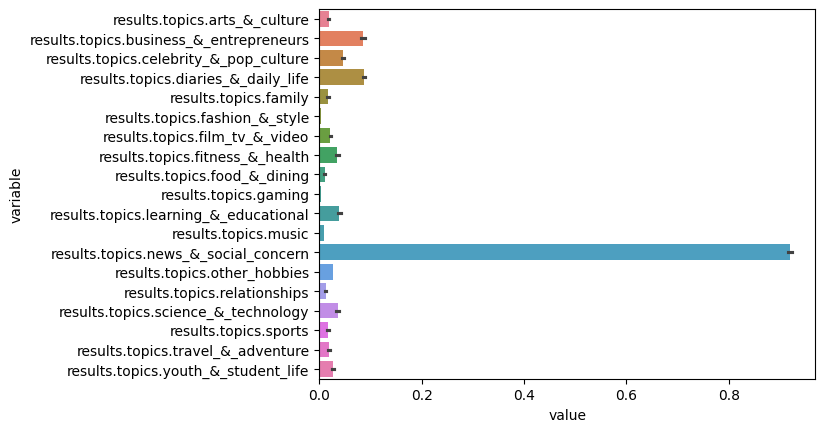

In [7]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

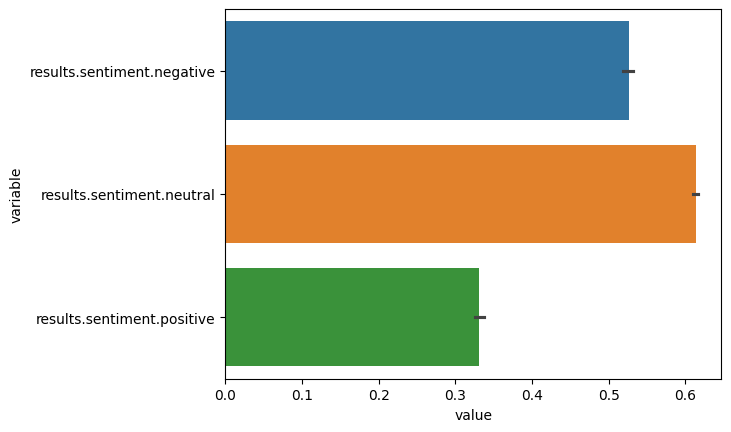

In [8]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

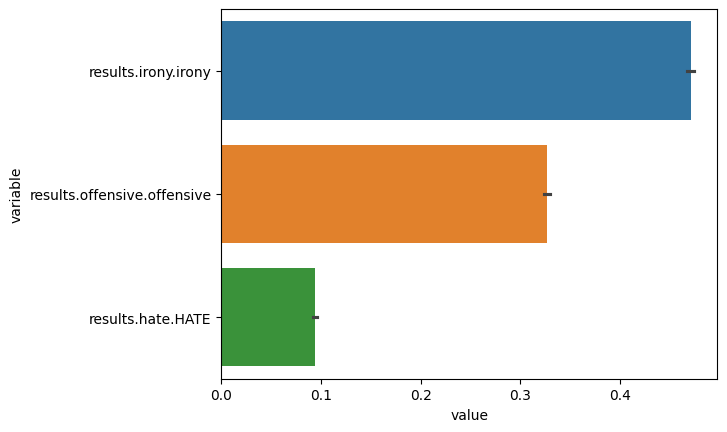

In [9]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value", y="variable", hue="variable",
)